In [1]:
import numpy as np
import matplotlib.pyplot as plt

from confusion import ConfusionMatrix
from loader import echo_study
from util import resolve_compensation_value

✅ Loaded 110 entries
🚨 Rejected 144 entries


In [2]:
def plot_confusion(conditions, title, label_fields):
    fig, axes = plt.subplots(nrows=1, ncols=len(conditions), figsize=(6 * len(conditions), 6))
    axes_iter = iter(axes)
    fig.suptitle(title, size=20)
    for condition in conditions:
        responses = condition.get_participants_responses()
        label = condition.label(*label_fields)
        mtx = ConfusionMatrix.of_azimuths(responses)
        axis = next(axes_iter)
        axis.set_title(f"{label} (n={condition.count()})")
        axis.imshow(mtx.normalized, extent=[-90, 90, -90, 90])
        axis.set_xlabel("Reported azimuth (degrees)")
        axis.set_ylabel("True azimuth (degrees)")
    plt.show()


/Users/ian/supernormal-echolocation-analysis/confusion.py:17: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(self.totals / self.totals.sum(axis=axis, keepdims=1), 0)


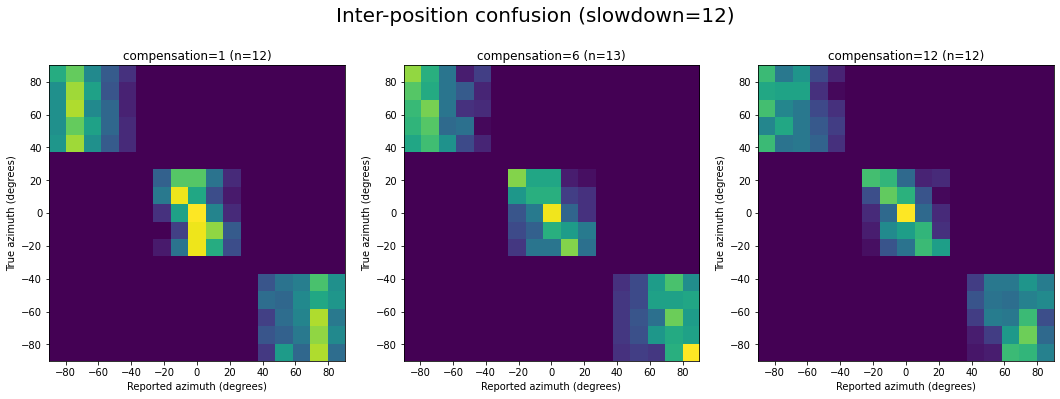

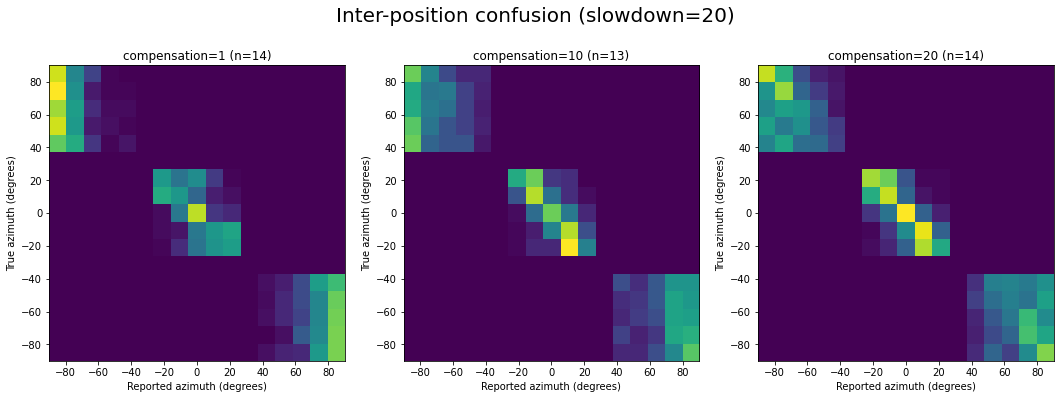

In [3]:

for slowdown in (12, 20):
    conditions = echo_study.subsect(slowdown=slowdown, compensation=[1, slowdown // 2, slowdown])
    plot_confusion(conditions, f"Inter-position confusion (slowdown={slowdown})", ["compensation"])

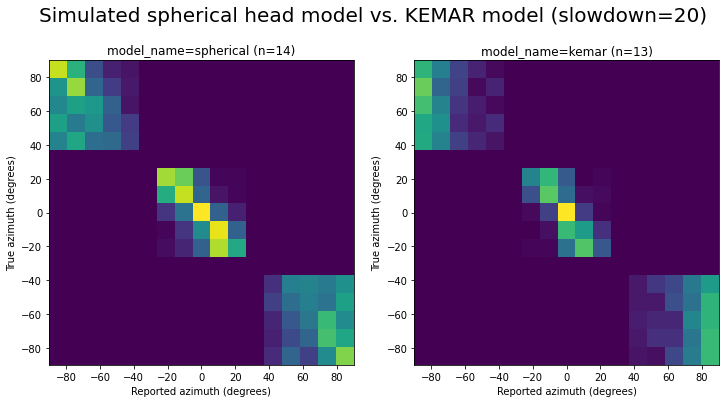

In [4]:
conditions = echo_study.spherical_vs_kemar(compensation=20, slowdown=20)
plot_confusion(conditions, "Simulated spherical head model vs. KEMAR model (slowdown=20)", ["model_name"])


In [5]:
from confusion import ConfusionMatrix
from sensitivity import get_interstim_sensitivities, log_fit_sensitivities

def plot_sensitivities(conditions, title, get_display_elements):
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(title, size=20)
    for condition in conditions:
        color, marker, linestyle, label = get_display_elements(**condition.values)
        responses = condition.get_participants_responses()
        if len(responses) == 0:
            continue
        cm = ConfusionMatrix.of_indices(responses)
        s = get_interstim_sensitivities(cm)
        x, y = log_fit_sensitivities(s)
        plt.plot(
            x,
            y,
            color=color,
            label=f"{label} (log)",
            linestyle=linestyle)
        plt.plot(*zip(*s), color=color, marker=marker, linestyle="None")
    plt.xlabel("Inter-stimulus distance (positions)")
    plt.ylabel("Sensitivity index (d')")
    plt.legend(loc="lower right")
    plt.show()



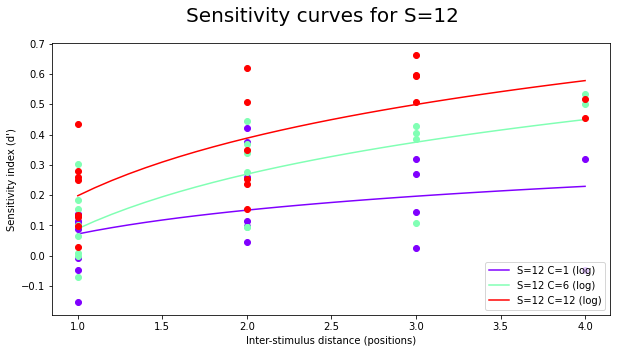

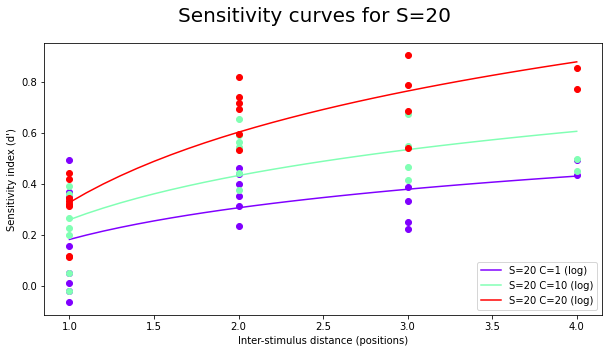

In [6]:
colors = plt.cm.rainbow(np.linspace(0, 1, 3))
compensation_colors = {
    "1": colors[0],
    "half": colors[1],
    "full": colors[2], 
}

def _get_display_elements(slowdown, compensation_descriptor, **rest):
    color = compensation_colors[compensation_descriptor]
    compensation = resolve_compensation_value(slowdown, compensation_descriptor)
    marker = 'o'
    linestyle = '-'
    label = f"S={slowdown} C={compensation}"
    return color, marker, linestyle, label

for slowdown in (12, 20):
    conditions = echo_study.subsect(slowdown=slowdown, compensation_descriptor=["1", "half", "full"])
    plot_sensitivities(conditions, f"Sensitivity curves for S={slowdown}", _get_display_elements)

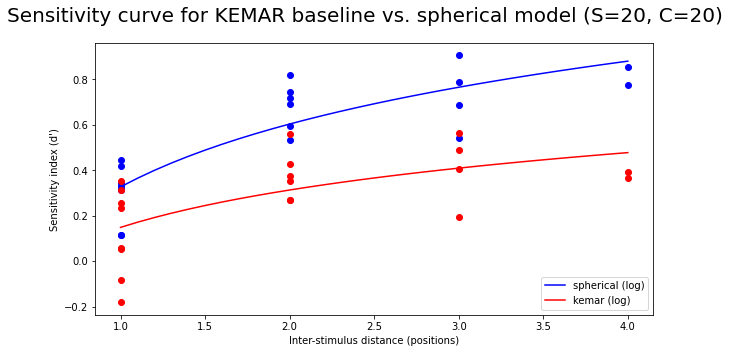

In [7]:
def _get_display_elements(model_name, **rest):
    color = "red" if model_name == "kemar" else "blue"
    marker = "o"
    linestyle = "-"
    label = model_name
    return color, marker, linestyle, label

conditions = echo_study.spherical_vs_kemar(slowdown=20, compensation=20)
plot_sensitivities(conditions, "Sensitivity curve for KEMAR baseline vs. spherical model (S=20, C=20)", _get_display_elements)